In [18]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob
from skimage import io, segmentation, feature, measure

In [19]:
ZIP_PATH = "/kaggle/input/competitions/data-science-bowl-2018/stage1_train.zip"
EXTRACT_PATH = "/kaggle/working/stage1_train"

os.makedirs(EXTRACT_PATH, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

print("Extraction complete.")

Extraction complete.


In [20]:
DATA_PATH = EXTRACT_PATH
image_ids = os.listdir(DATA_PATH)

print("Total images:", len(image_ids))

Total images: 670


In [21]:
def load_image(image_id):
    image_folder = os.path.join(DATA_PATH, image_id, "images")
    image_path = glob(os.path.join(image_folder, "*"))[0]
    return io.imread(image_path)

In [22]:
def load_ground_truth(image_id):
    mask_folder = os.path.join(DATA_PATH, image_id, "masks")
    mask_files = glob(os.path.join(mask_folder, "*"))
    
    combined_mask = None
    
    for mask_path in mask_files:
        mask = io.imread(mask_path)
        if mask.ndim == 3:
            mask = mask[..., 0]
        
        if combined_mask is None:
            combined_mask = np.zeros_like(mask)
        
        combined_mask = np.maximum(combined_mask, mask)
    
    return combined_mask

In [23]:
def preprocess(image):
    
    if image.ndim == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    blur = cv2.GaussianBlur(gray, (5,5), 0)

    _, binary = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    if np.mean(binary) > 127:
        binary = 255 - binary

    return gray, binary

In [24]:
def watershed_without_markers(binary):
    distance = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    markers = measure.label(binary)
    return segmentation.watershed(-distance, markers, mask=binary)

In [25]:
def watershed_with_markers(binary, min_distance=10):
    
    distance = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    
    local_max = feature.peak_local_max(
        distance,
        footprint=np.ones((3,3)),
        min_distance=min_distance,
        labels=binary
    )
    
    markers = np.zeros_like(distance, dtype=np.int32)
    
    for i, coord in enumerate(local_max):
        markers[coord[0], coord[1]] = i + 1

    return segmentation.watershed(-distance, markers, mask=binary)

In [26]:
def dice_score(pred, true):
    pred = pred > 0
    true = true > 0
    intersection = np.logical_and(pred, true).sum()
    return (2.0 * intersection) / (pred.sum() + true.sum() + 1e-8)

def iou_score(pred, true):
    pred = pred > 0
    true = true > 0
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    return intersection / (union + 1e-8)


Image 1
Without Markers → Dice: 0.8827, IoU: 0.7901
With Markers    → Dice: 0.8605, IoU: 0.7551

Image 2
Without Markers → Dice: 0.9677, IoU: 0.9375
With Markers    → Dice: 0.9679, IoU: 0.9378

Image 3
Without Markers → Dice: 0.9653, IoU: 0.9330
With Markers    → Dice: 0.9636, IoU: 0.9297

Image 4
Without Markers → Dice: 0.9331, IoU: 0.8745
With Markers    → Dice: 0.9081, IoU: 0.8316


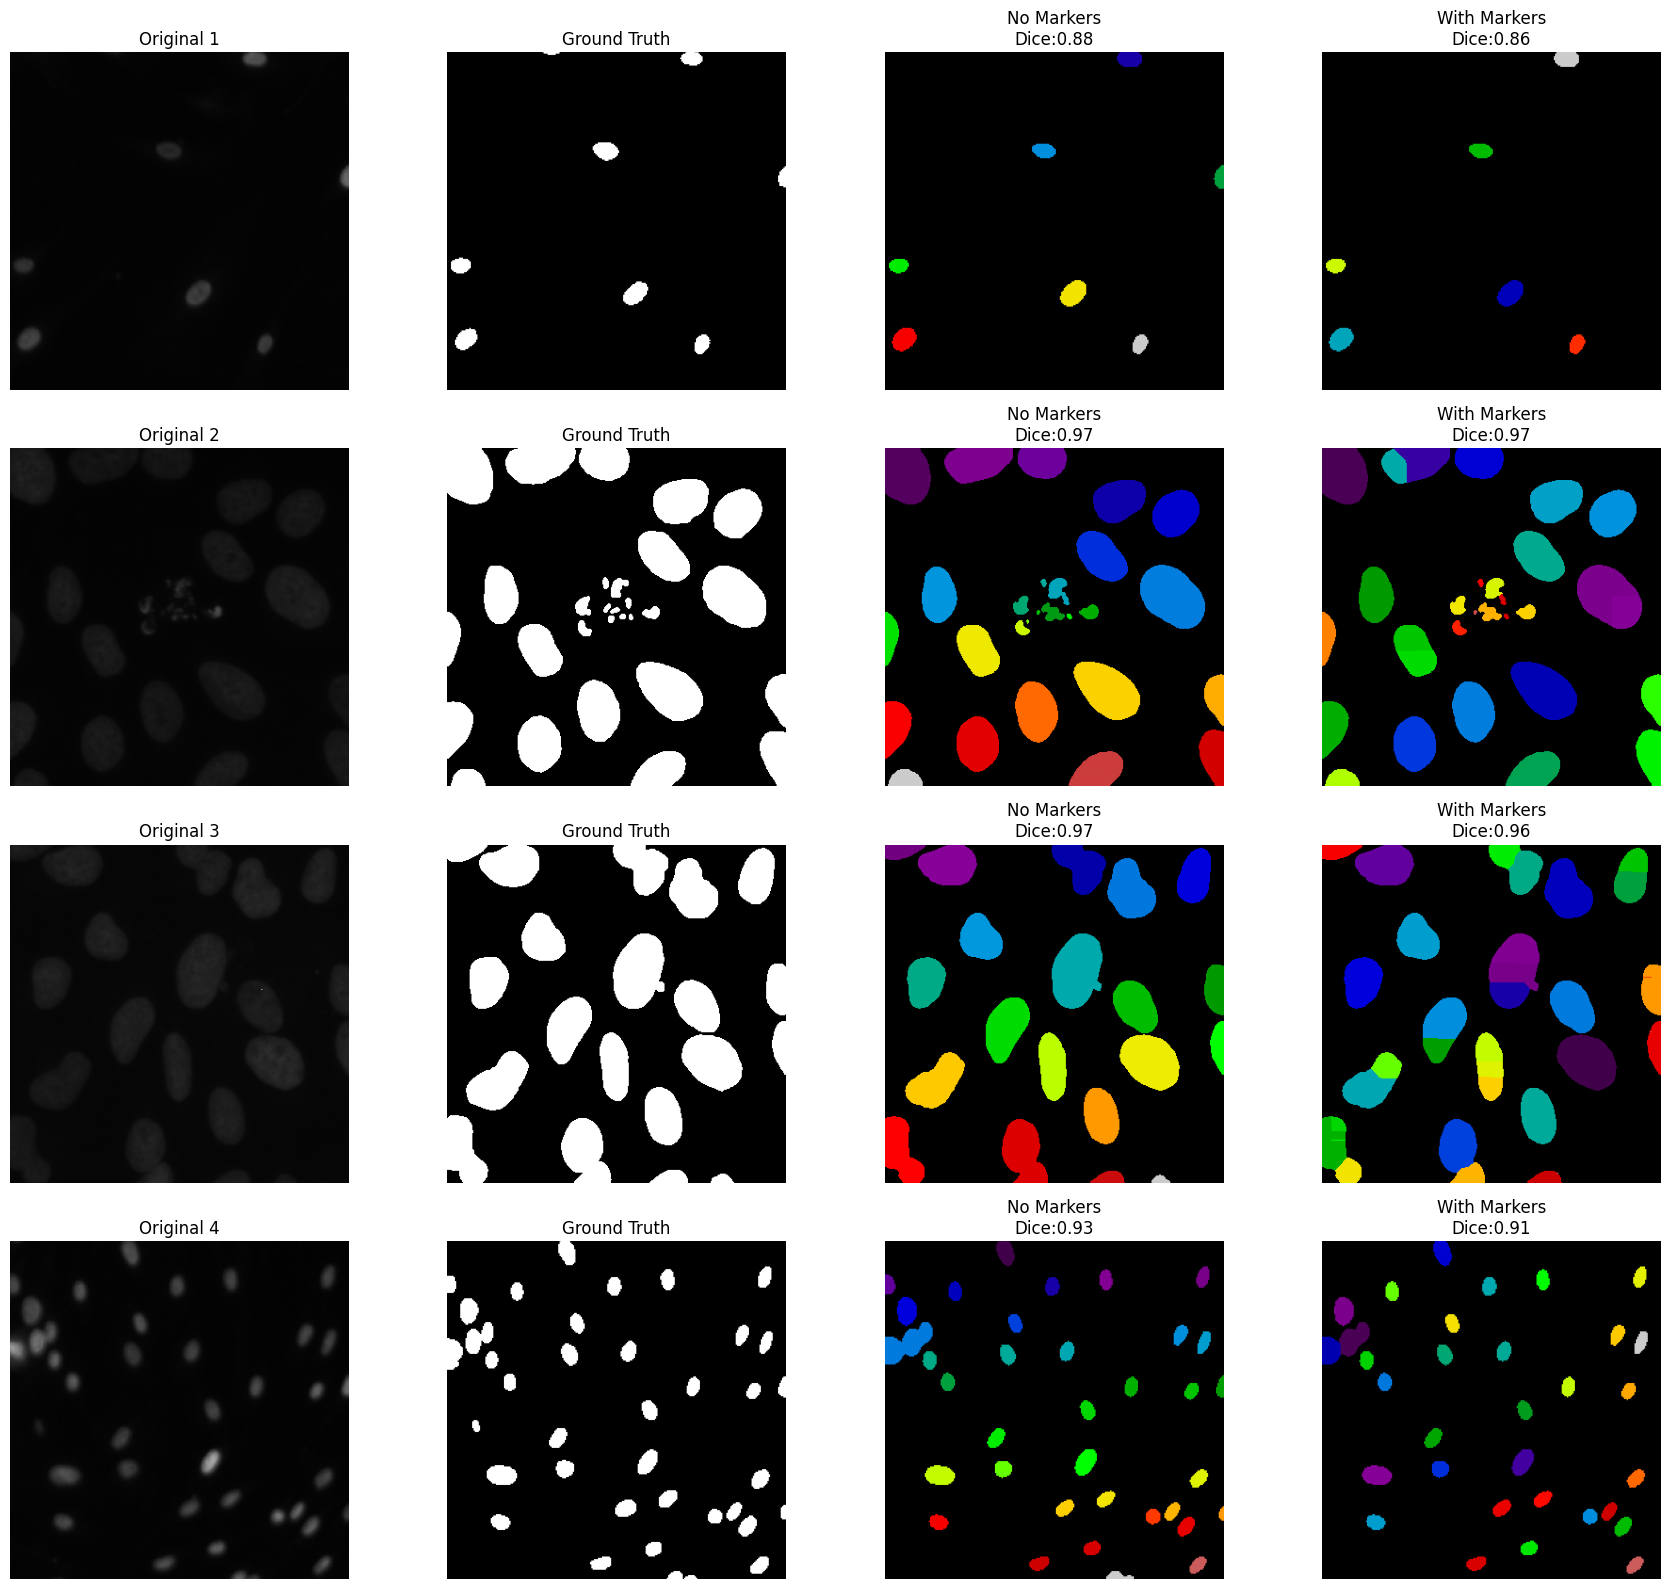

In [27]:
NUM_DISPLAY = 4
selected_ids = image_ids[:NUM_DISPLAY]

plt.figure(figsize=(18, NUM_DISPLAY * 4))

for idx, image_id in enumerate(selected_ids):
    
    image = load_image(image_id)
    gt_mask = load_ground_truth(image_id)
    
    _, binary = preprocess(image)
    
    labels_no = watershed_without_markers(binary)
    labels_with = watershed_with_markers(binary)
    
    pred_no = labels_no > 0
    pred_with = labels_with > 0
    
    dice_no = dice_score(pred_no, gt_mask)
    dice_with = dice_score(pred_with, gt_mask)
    
    iou_no = iou_score(pred_no, gt_mask)
    iou_with = iou_score(pred_with, gt_mask)
    
    print(f"\nImage {idx+1}")
    print(f"Without Markers → Dice: {dice_no:.4f}, IoU: {iou_no:.4f}")
    print(f"With Markers    → Dice: {dice_with:.4f}, IoU: {iou_with:.4f}")
    
    plt.subplot(NUM_DISPLAY, 4, idx*4 + 1)
    plt.imshow(image)
    plt.title(f"Original {idx+1}")
    plt.axis("off")
    
    plt.subplot(NUM_DISPLAY, 4, idx*4 + 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(NUM_DISPLAY, 4, idx*4 + 3)
    plt.imshow(labels_no, cmap="nipy_spectral")
    plt.title(f"No Markers\nDice:{dice_no:.2f}")
    plt.axis("off")
    
    plt.subplot(NUM_DISPLAY, 4, idx*4 + 4)
    plt.imshow(labels_with, cmap="nipy_spectral")
    plt.title(f"With Markers\nDice:{dice_with:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [28]:
dice_no_all = []
iou_no_all = []

dice_with_all = []
iou_with_all = []

print("\nEvaluating full dataset...")

for image_id in image_ids:
    
    image = load_image(image_id)
    gt_mask = load_ground_truth(image_id)
    
    _, binary = preprocess(image)
    
    labels_no = watershed_without_markers(binary)
    labels_with = watershed_with_markers(binary)
    
    pred_no = labels_no > 0
    pred_with = labels_with > 0
    
    dice_no_all.append(dice_score(pred_no, gt_mask))
    iou_no_all.append(iou_score(pred_no, gt_mask))
    
    dice_with_all.append(dice_score(pred_with, gt_mask))
    iou_with_all.append(iou_score(pred_with, gt_mask))

print("Full dataset evaluation complete.")


Evaluating full dataset...
Full dataset evaluation complete.


In [29]:
avg_dice_no = np.mean(dice_no_all)
avg_iou_no = np.mean(iou_no_all)

avg_dice_with = np.mean(dice_with_all)
avg_iou_with = np.mean(iou_with_all)

print("\n================ FINAL AVERAGE (ALL IMAGES) ================")

print("\nWITHOUT MARKERS:")
print(f"Average Dice: {avg_dice_no:.4f}")
print(f"Average IoU : {avg_iou_no:.4f}")

print("\nWITH MARKERS:")
print(f"Average Dice: {avg_dice_with:.4f}")
print(f"Average IoU : {avg_iou_with:.4f}")


================ FINAL AVERAGE (ALL IMAGES) ================

WITHOUT MARKERS:
Average Dice: 0.8580
Average IoU : 0.7766

WITH MARKERS:
Average Dice: 0.8453
Average IoU : 0.7569
